In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sctour as sct
from matplotlib import cm, colors

Preprocessing including filtering out genes detected in less than 20 cells and selecting the top 2000 highly variable genes, and further removing cycling genes which were collected from Suo et al., 2022 (https://github.com/Teichlab/Pan_fetal_immune).

In [2]:
adata = sc.read('../../../HVG_1000_latent_10_after_qc.h5ad')
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3', subset=True, batch_key='ID')
cc_genes = pd.read_csv('../../../cc_genes.csv', index_col=0)['0'].values
ggs = [g for g in adata.var_names if g not in cc_genes]
adata = adata[:, ggs]

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


The tool scTour was used here to infer the transcriptomic vector field.

In [3]:
tnode = sct.train.Trainer(adata)
tnode.train()
adata.obs['ptime'] = tnode.get_time()
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.7, alpha_predz=0.3)
adata.obsm['X_TNODE'] = mix_zs
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, mix_zs)

Epoch 294: 100%|██████████| 294/294 [45:58<00:00,  8.92s/epoch, train_loss=684, val_loss=692]    
Trying to set attribute `.obs` of view, copying.


Visualize the inferred vector field under a UMAP embedding.

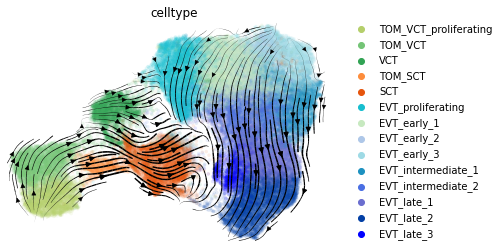

In [4]:
sct.vf.plot_vector_field(adata, vf_key='X_VF', zs_key='X_TNODE', use_rep_neigh='X_TNODE', color='celltype', n_neigh=15, size=50, alpha=0.1, frameon=False)
plt.show()